In [68]:
import string
import pandas as pd
from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import re
import pymongo
import pymongo.database
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models
from gensim.models import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [86]:
def update_content_table(content: dict):
    my_client: pymongo.MongoClient = pymongo.MongoClient("mongodb://localhost:27017/")
    my_db: pymongo.database.Database = my_client["final-year-project"]
    content: pymongo.database.Collection = my_db["content"]
    try:
        # Define the filter and update operation
        filter_criteria = {"_id": content["_id"]}  # Assuming 'id' is an attribute of Content
        update_operation = {"$set": content}  # Update with content's attributes
        
        print("Going to update")
        result = content.update_one(filter_criteria, update_operation)
        
        if result.matched_count > 0:
            print(f"Updated document with ID: {content['_id']}")
        else:
            print("No matching document found for update.")
        
    except Exception as e:
        print(f"An error occurred: {e}")
        
def get_all_url():
    my_client: pymongo.MongoClient = pymongo.MongoClient("mongodb://localhost:27017/")
    my_db: pymongo.database.Database = my_client["final-year-project"]
    url: pymongo.database.Collection = my_db["url"]
    try:
        result = url.find()
        return list(result)
    except Exception as e:
        print(f"An error occurred: {e}")
        return []
    
def get_all_content():
    my_client: pymongo.MongoClient = pymongo.MongoClient("mongodb://localhost:27017/")
    my_db: pymongo.database.Database = my_client["final-year-project"]
    content: pymongo.database.Collection = my_db["content"]
    try:
        result = content.find()
        return list(result)
    except Exception as e:
        print(f"An error occurred: {e}")
        return []
    
def insert_preprorcessed_content_table(content: dict):
    my_client: pymongo.MongoClient = pymongo.MongoClient("mongodb://localhost:27017/")
    my_db: pymongo.database.Database = my_client["final-year-project"]
    preprocessed_content: pymongo.database.Collection = my_db["preprocessed_content"]
    try:
        print("Going to insert")
        result = preprocessed_content.insert_one(content)
        print(f"Inserted document with ID: {result.inserted_id}")
        
    except Exception as e:
        print(f"An error occurred: {e}")

NLTK download

In [70]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wwwhh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wwwhh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wwwhh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\wwwhh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

Query database

In [71]:
filter_words = ['china', 'chinese', 'sumerian', 'sumerians', 'sumer', 'shang', 'xia', 'cuneiform']

def deduplication(list_of_dicts):
    deduplicated = []
    text_seen = set()
    for d in list_of_dicts:
        if d['text'] not in text_seen:
            text_seen.add(d['text'])
            deduplicated.append(d)
            
    return deduplicated

def filter(tokens):
    for word in tokens:
        if word in filter_words:
            return True
        
    return False


def tokenization(text):
    # Lowercase
    text = text.lower()
    
    # Remove URLs and email addresses
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    # Remove punctuation and numbers
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r'\d+', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    gensim_stopwords = list(STOPWORDS)
    sklearn_stopwords = list(ENGLISH_STOP_WORDS)
    custom_stopwords = set(['going', 'im', 'one', 'go', 'people', 'say', 'get', 'know', 'think', 'like', 'want', 'make', 'thing', 'good', 'really', 'time', 'look', 'come', 'see', 'would', 'could', 'may', 'might', 'must', 'shall', 'should', 'will', 'ought', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten'])
    stop_words = stop_words.union(custom_stopwords)
    stop_words = stop_words.union(gensim_stopwords)
    stop_words = stop_words.union(sklearn_stopwords)
    tokens = [word for word in tokens if word not in stop_words]
    
    if not filter(tokens):
        return ""
    
    # POS tagging
    tagged_tokens = nltk.pos_tag(tokens)
    # Lemmatization and remove adverbs
    lemmatizer = WordNetLemmatizer()
    tokens = [
        lemmatizer.lemmatize(word, pos='v') for word, pos in tagged_tokens if pos[0] != 'R'
    ]
    
    return tokens

Plot graph

In [72]:
from pandas import DataFrame

def record_source(df: DataFrame):
    # Count occurrences by source
    source_counts = df['source'].value_counts()
    
    # Plotting
    plt.figure(figsize=(8, 6))
    source_counts.plot(kind='bar', color=['blue', 'orange'])
    plt.title('Count of Records by Source')
    plt.xlabel('Source')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()
    
def record_word_count_bar_chart(df):
    # Calculate word count
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))

    # Define bins for word count categories
    bins = [0, 100, 200, 500, 1000, 2000, 5000, 7500]
    labels = ['0-100', '101-200', '201-500', '501-1000', '1001-2000', '2001-5000', '5001-7500']
    
    # Cut the word counts into bins
    df['word_count_category'] = pd.cut(df['word_count'], bins=bins, labels=labels, right=False)
    
    # Count the frequency of each category
    category_counts = df['word_count_category'].value_counts().sort_index()

    # Plotting the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(category_counts.index, category_counts.values, color='skyblue', alpha=0.7)
    
    # Set title and labels
    plt.title('Word Count Distribution by Category')
    plt.xlabel('Word Count Categories')
    plt.ylabel('Frequency')
    
    plt.xticks(rotation=45)
    
    plt.grid(axis='y')
    
    plt.show()

WordCloud

In [73]:
def wordcloud(texts_series):
    preprocessed_docs = ' '.join(text for text_list in texts_series for text in text_list)

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(preprocessed_docs)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide axes
    plt.show()

<h1>Add a new column for preprocessed data<h1>

In [74]:
deduplication = deduplication(get_all_content())
df = pd.DataFrame(deduplication)
df['preprocessed_text'] = df['text'].apply(tokenization)

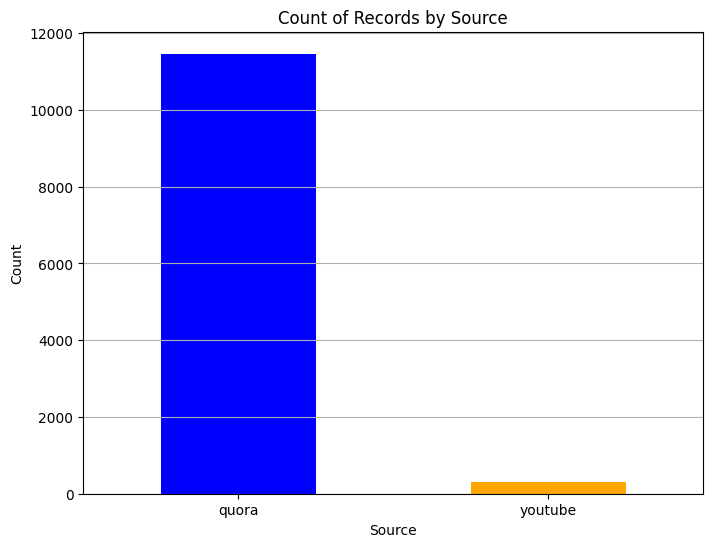

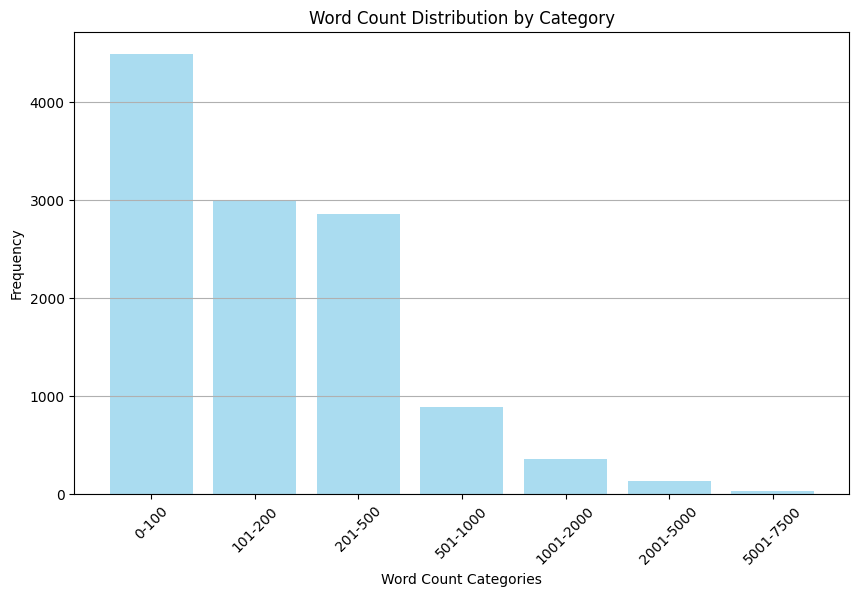

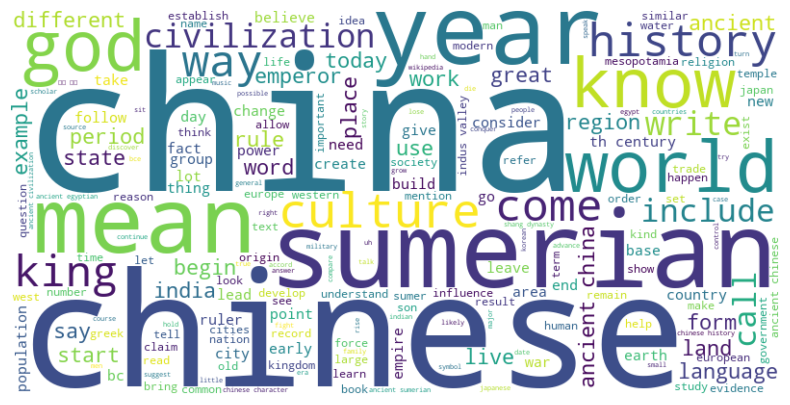

In [76]:
record_source(df)
record_word_count_bar_chart(df)
wordcloud(df['preprocessed_text'])

In [78]:
columns = ['text', 'search_keyword', 'url', 'source', 'preprocessed_text','word_count', 'word_count_category']
preprocessed_df = df[columns]

In [ ]:
for index, row in preprocessed_df.iterrows():
    insert_preprorcessed_content_table(row.to_dict())